# Load and Plot SWOT EXPERT Data

In [1]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
#%matplotlib widget # magic matplotlib (if you want that)

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

Log into earthaccess

In [3]:
auth = earthaccess.login(persist=True)

Check the names of the SWOT datasets available on earthaccess

In [4]:
# results = earthaccess.search_datasets(keyword="swot")
# for item in results:
#     summary = item.summary()
#     print(summary["short-name"])

In [5]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

### Looking for Gulf Stream Ring <3 Edward <3

In [6]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68

# These bounds are fucked in the SWOT data. Thinking maybe it's not atmospheric corrected? Clouds?
#latmin,latmax = 32,45
#lonmin,lonmax = -75,-66

In [7]:
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 88


QUEUEING TASKS | :   0%|          | 0/88 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/88 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/88 [00:00<?, ?it/s]

Get all dates with SWOT swaths through the bounding box

In [8]:
dates_available = []
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20240405', '20240406', '20240407', '20240408', '20240416', '20240417', '20240418', '20240420', '20240426', '20240427', '20240428', '20240429', '20240507', '20240508', '20240509', '20240517', '20240518', '20240519', '20240523', '20240527', '20240528', '20240529', '20240530', '20240531', '20240607', '20240608', '20240609', '20240613', '20240617', '20240618', '20240619', '20240620', '20240621', '20240628', '20240629', '20240630', '20240704', '20240708', '20240709', '20240710', '20240711', '20240712', '20240719', '20240720', '20240721', '20240725', '20240729', '20240730', '20240801']


Get data from a specific date

NOTE: 2024/05/23 isn't cropping

In [9]:
date_requested = '20240508'

ind = 0 
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind)
    ind += 1

23
24


There are 2 swaths on the date of interest

In [13]:
print(edward_paths[23])
print(edward_paths[24])

<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_014_576_20240508T002317_20240508T011320_PIC0_01.nc>
<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_015_007_20240508T131334_20240508T140502_PIC0_01.nc>


Open a single dataset.

NOTE: Will need to point to different indices if you change the bounding box

In [14]:
ds1 = xr.open_dataset(edward_paths[23])
ds2 = xr.open_dataset(edward_paths[24])

In [15]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [16]:
ds1_masked = crop_dataset_by_lat_lon(ds1,latmin,latmax,lonmin,lonmax)
ds2_masked = crop_dataset_by_lat_lon(ds2,latmin,latmax,lonmin,lonmax)

Need to add 'height_cor_xover' values to ssh & sla variabiles

<Figure size 640x480 with 0 Axes>

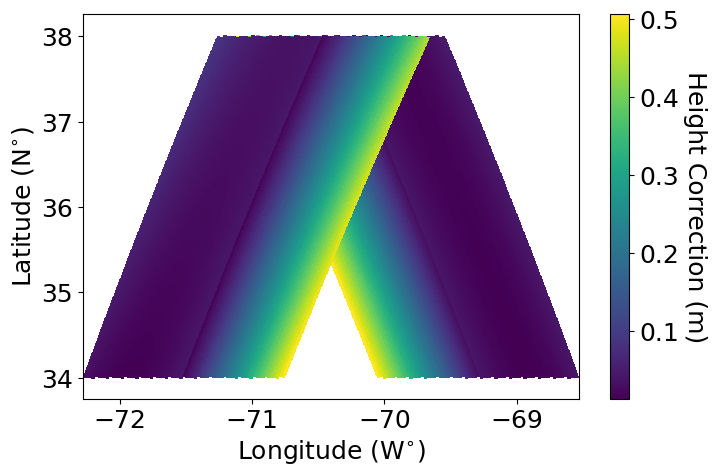

In [17]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude-360,ds1_masked.latitude,ds1_masked.height_cor_xover)
plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,ds2_masked.height_cor_xover)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('Height Correction (m)', rotation=270, labelpad=20)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (W$^{\circ}$)')

plt.show()

SSHA Karin 2 is the best quality to show the eddy

<Figure size 640x480 with 0 Axes>

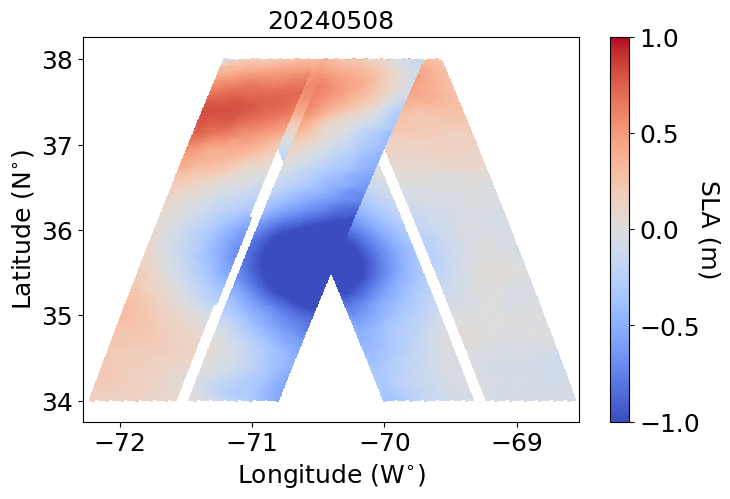

In [18]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude-360,ds1_masked.latitude,ds1_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,ds2_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)

#plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm',vmin=-1,vmax=1)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (W$^{\circ}$)')
ax.set_title(date_requested)

plt.show()

Plot overlap

<Figure size 640x480 with 0 Axes>

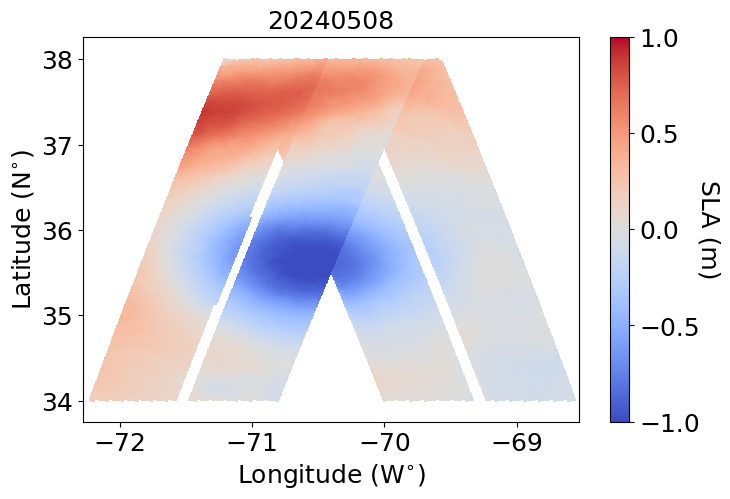

In [19]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude-360,ds1_masked.latitude,np.add(ds1_masked.ssha_karin_2,ds1_masked.height_cor_xover),cmap='coolwarm',vmin=-1,vmax=1)
ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (W$^{\circ}$)')
ax.set_title(date_requested)

plt.show()

Regrid SWOT data to regular grid. Need to do this before taking spatial gradients for velocity calculations.

In [20]:
#bbox = (-73, 35, -70, 37) #edward


xv = np.arange(287, 293, 0.036)
yv = np.arange(33,39, 0.036)
grid_x, grid_y = np.meshgrid(xv, yv)
ssh=ds1_masked.ssha_karin_2+ds1_masked.height_cor_xover
lat=ds1_masked.latitude
lon=ds1_masked.longitude
grid_ssh1 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')
ssh=ds2_masked.ssha_karin_2+ds2_masked.height_cor_xover
lat=ds2_masked.latitude
lon=ds2_masked.longitude
grid_ssh2 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')

Plot regridded SSH

<Figure size 640x480 with 0 Axes>

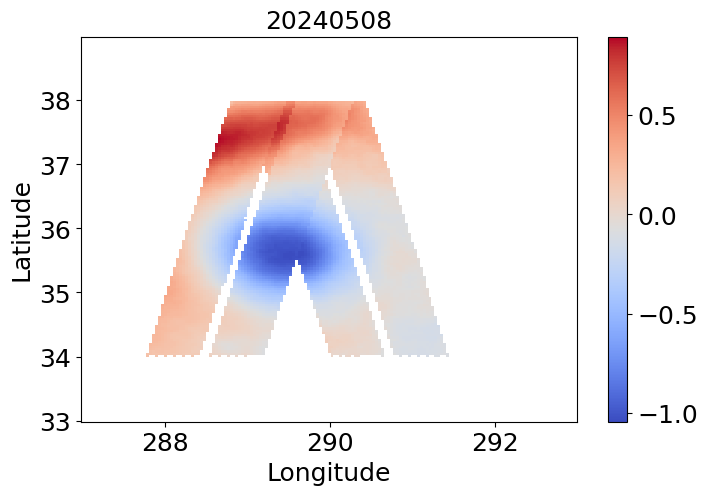

In [21]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh1,cmap='coolwarm')
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

In [22]:
def compute_geos_current(ssh,lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx = 4000 # m i changed it to 4000 to match res? need to double check
    dy = 4000 # m
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    # ds_x,ds_y=np.array(np.gradient(ssh))
    # dsdx=ds_x/dx;
    # dsdy=ds_y/dx;
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    # ref_gx, ref_gy = gravity/np.array(f_coriolis)*np.array(np.gradient(ssh, dx, edge_order=2))
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

Compute geostrophic currents

In [23]:
#Calculate
ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)
ug2,vg2,geos_current2 = compute_geos_current(grid_ssh2,grid_y)

<Figure size 640x480 with 0 Axes>

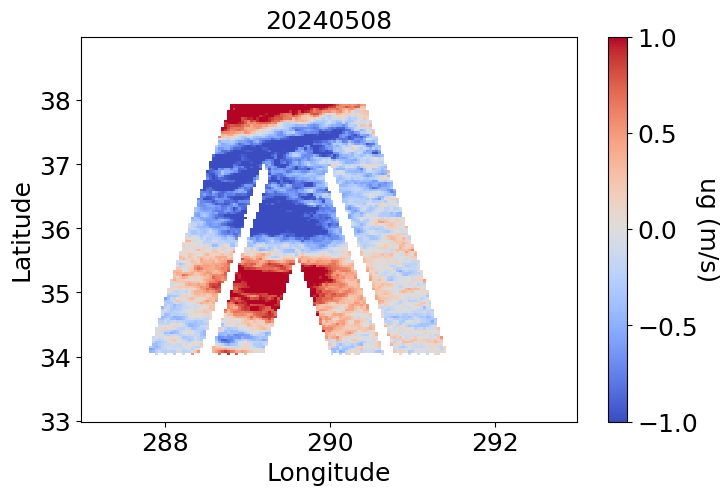

<Figure size 640x480 with 0 Axes>

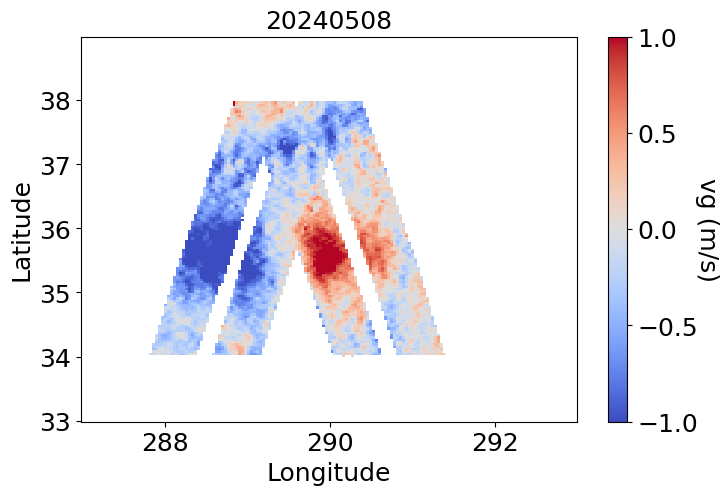

In [24]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,ug1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,ug2,cmap='coolwarm',vmin=-1,vmax=1)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('ug (m/s)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,vg1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,vg2,cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('vg (m/s)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

In [25]:
def compute_relative_vorticity(ug, vg, lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    # ds = self._dset
        
    dx = 4000 # m
    dy = 4000 # m
        
    # du_dx, du_dy = np.gradient(ug, dx, edge_order=2)
    # dv_dx, dv_dy = np.gradient(vg, dx, edge_order=2)
    du_dy, du_dx = np.gradient(ug, dx, edge_order=2)
    dv_dy, dv_dx = np.gradient(vg, dx, edge_order=2)
        
    ksi = (dv_dx - du_dy)/f_coriolis
        
    return ksi

Compute geostrophic vorticity. Smoothing is in the x,y direction, not along track, which is why the swath shrinks. Future problem to fix to increase swath of vorticity

<Figure size 640x480 with 0 Axes>

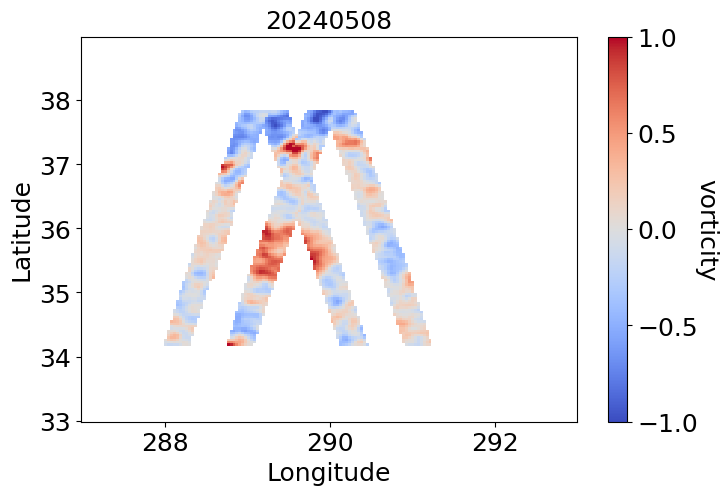

In [26]:
wfl=5
ug_smooth1=xr.apply_ufunc(generic_filter,ug1, np.mean, [wfl,wfl])
vg_smooth1=xr.apply_ufunc(generic_filter,vg1, np.mean, [wfl,wfl])
ug_smooth2=xr.apply_ufunc(generic_filter,ug2, np.mean, [wfl,wfl])
vg_smooth2=xr.apply_ufunc(generic_filter,vg2, np.mean, [wfl,wfl])
# ug_smooth1=gaussian_filter(ug1,1)
# vg_smooth1=gaussian_filter(vg1,1)
# ug_smooth2=gaussian_filter(ug2,1)
# vg_smooth2=gaussian_filter(vg2,1)
ksi1=compute_relative_vorticity(ug_smooth1, vg_smooth1, grid_y)
ksi2=compute_relative_vorticity(ug_smooth2, vg_smooth2, grid_y)

plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,ksi1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,ksi2,cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('vorticity', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

### Load in PACE Data

In [27]:
results = earthaccess.search_datasets(instrument="oci")

tspan = ("2024-05-08", "2024-05-08")
#bbox = (-58, 37.5, -52, 41) #howie
bbox = (-73, 35, -70, 37) #edward
# bbox=(-61, 34, -59, 39) #patrick
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

paths = earthaccess.open(results) #'streaming' data

datatree = open_datatree(paths[0])
datatree
dataset = xr.merge(datatree.to_dict().values())
dataset
dataset = dataset.set_coords(("longitude", "latitude"))

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
h=str(paths[0])
datey=h[64:72]

Load eddy data to plot contour on top of chl

In [29]:
aviso_ds = xr.open_dataset('Edward_Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc')
aviso_ds

<xarray.Dataset> Size: 202kB
Dimensions:                        (obs: 223, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float64 2kB ...
    effective_area                 (obs) float32 892B ...
    effective_contour_height       (obs) float32 892B ...
    effective_contour_latitude     (obs, NbSample) float64 36kB ...
    effective_contour_longitude    (obs, NbSample) float64 36kB ...
    effective_contour_shape_error  (obs) float64 2kB ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 36kB ...
    speed_contour_shape_error      (obs) float64 2kB ...
    speed_radius                   (obs) float64 2kB ...
    time                           (obs) datetime64[ns] 2kB ...
    track                          (obs) uint32 892B ...
    uavg_profile                   (obs, NbSample) float64 36kB ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2024-08-06T09:38:06Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2396D
    time_coverage_end:         2024-07-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

In [30]:
def get_eddy_by_ID_date(ds,eddy_date):
    """
    ds: netCDF AVISO format
    track_id: id of eddy to extract
    eddy_date: date in format 'YYYY-MM-DD'

    Returns contour lons, contour lats, center lon, center lat
    """
    try:
        ind = np.where(ds.time == np.datetime64(eddy_date))[0][0]
        contour_lons = np.array(ds.effective_contour_longitude[ind])
        contour_lats = np.array(ds.effective_contour_latitude[ind])
    except:
        print('No eddy data available with that request ... :(')        
    
    return contour_lons,contour_lats,ds.longitude[ind],ds.latitude[ind]

In [31]:
contour_lons,contour_lats,center_lon,center_lat = get_eddy_by_ID_date(aviso_ds,'2024-05-08')

Text(0.5, 1.0, '2024-05-08')

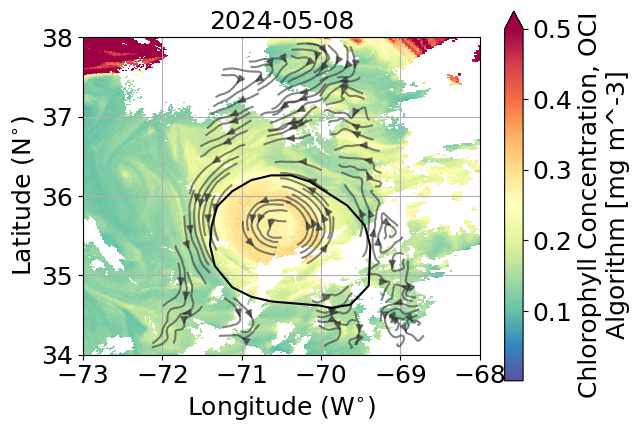

In [35]:
grid_x_180 = grid_x - 360 #only works for >180˚

fig = plt.figure()
ax = plt.axes()#projection=ccrs.PlateCarree())
#ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
#plot=plt.pcolor(dataset["longitude"].values,dataset["latitude"].values,dataset["chlor_a"].values, cmap="Spectral_r", vmax=0.5,transform=ccrs.PlateCarree())
ax.grid(True)
#ax.streamplot(grid_x_180,grid_y,ug1,vg1,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
#ax.streamplot(grid_x_180,grid_y,ug2,vg2,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
ax.streamplot(grid_x_180,grid_y,ug1,vg1, density = 3, color = (0.2,0.2,0.2,0.6))
ax.streamplot(grid_x_180,grid_y,ug2,vg2, density = 3, color = (0.2,0.2,0.2,0.6))

ax.plot(contour_lons-360,contour_lats,zorder=100,c='k')

ax.axis("scaled")
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (W$^{\circ}$)')
ax.set_ylim([34,38])
ax.set_xlim([-73,-68])
ax.set_title(datey[0:4]+'-'+datey[4:6]+'-'+datey[6:len(datey)])

Text(0.5, 1.0, '2024-05-08')

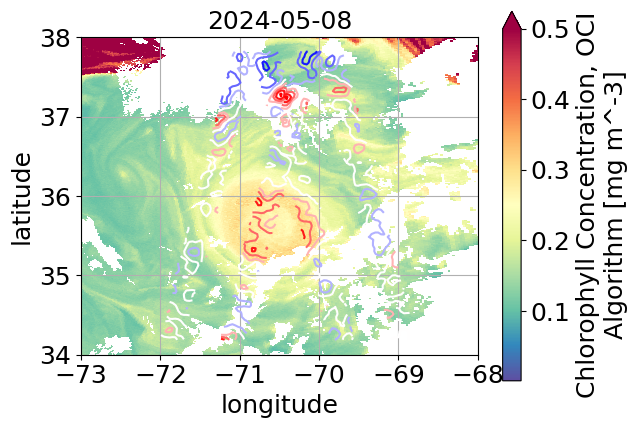

In [157]:
fig = plt.figure()
ax = plt.axes()#projection=ccrs.PlateCarree())
#ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
#plot=plt.pcolor(dataset["longitude"].values,dataset["latitude"].values,dataset["chlor_a"].values, cmap="Spectral_r", vmax=0.5,transform=ccrs.PlateCarree())
ax.grid(True)
#ax.streamplot(grid_x_180,grid_y,ug1,vg1,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
#ax.streamplot(grid_x_180,grid_y,ug2,vg2,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
ax.contour(grid_x_180,grid_y,ksi1,cmap='bwr',vmin=-1,vmax=1)
ax.contour(grid_x_180,grid_y,ksi2,cmap='bwr',vmin=-1,vmax=1)
ax.axis("scaled")
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_ylim([34,38])
ax.set_xlim([-73,-68])
h=str(paths[0])
datey=h[64:72]
ax.set_title(datey[0:4]+'-'+datey[4:6]+'-'+datey[6:len(datey)])

plt.show()

<Figure size 640x480 with 0 Axes>

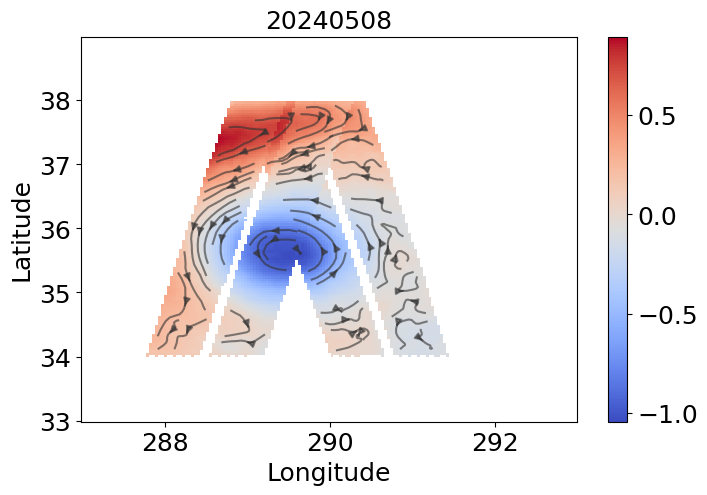

In [160]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh1,cmap='coolwarm')
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)
plt.streamplot(grid_x,grid_y,ug1,vg1, density = 2, color = (0.2,0.2,0.2,0.6))
plt.streamplot(grid_x,grid_y,ug2,vg2, density = 2, color = (0.2,0.2,0.2,0.6))

# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

### Add in low-res altimeter data (OSCAR)

In [36]:
results = earthaccess.search_datasets(keyword="oscar")
for item in results:
    summary = item.summary()
    print(summary["short-name"])

OSCAR_L4_OC_INTERIM_V2.0
OSCAR_L4_OC_NRT_V2.0
OSCAR_L4_OC_third-deg
OSCAR_L4_OC_1deg
OSCAR_L4_OC_third-deg_YEARLY
OSCAR_L4_OC_FINAL_V2.0


KeyError: 'FileDistributionInformation'

In [37]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

In [38]:
bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
results = earthaccess.search_data(
        short_name="OSCAR_L4_OC_NRT_V2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
oscar_paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

Number of swaths: 124


QUEUEING TASKS | :   0%|          | 0/124 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/124 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/124 [00:00<?, ?it/s]

In [39]:
dates_available = []
for i in oscar_paths:
    today = str(i).split('.')[-2].split('_')[-1]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20240403', '20240404', '20240405', '20240406', '20240407', '20240408', '20240409', '20240410', '20240411', '20240412', '20240413', '20240414', '20240415', '20240416', '20240417', '20240418', '20240419', '20240420', '20240421', '20240422', '20240423', '20240424', '20240425', '20240426', '20240427', '20240428', '20240429', '20240430', '20240501', '20240502', '20240503', '20240504', '20240505', '20240506', '20240507', '20240508', '20240509', '20240510', '20240511', '20240512', '20240513', '20240514', '20240515', '20240516', '20240517', '20240518', '20240519', '20240520', '20240521', '20240522', '20240523', '20240524', '20240525', '20240526', '20240527', '20240528', '20240529', '20240530', '20240531', '20240601', '20240602', '20240603', '20240604', '20240605', '20240606', '20240607', '20240608', '20240609', '20240610', '20240611', '20240612', '20240613', '20240614', '20240615', '20240616', '20240617', '20240618', '20240619', '20240620', '20240621', '20240622', '20240623', '20240624', '20

In [40]:
date_requested = '20240508'

ind = 0 
for i in oscar_paths:
    today = str(i).split('.')[-2].split('_')[-1]
    if date_requested == today:
        print(ind)
    ind += 1

35


In [41]:
print(oscar_paths[35])

<File-like object S3FileSystem, podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240508.nc>


In [42]:
oscar_ds = xr.open_dataset(oscar_paths[35])
oscar_ds = oscar_ds.transpose("time", "latitude", "longitude") # oscar reads in stupid, so just do this line.. trust me ;)
oscar_ds

<xarray.Dataset> Size: 33MB
Dimensions:  (latitude: 719, longitude: 1440, time: 1)
Coordinates:
    lat      (latitude) float64 6kB ...
    lon      (longitude) float64 12kB ...
  * time     (time) object 8B 2024-05-08 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 8MB ...
    v        (time, latitude, longitude) float64 8MB ...
    ug       (time, latitude, longitude) float64 8MB ...
    vg       (time, latitude, longitude) float64 8MB ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-05-08T00:00:00
    time_coverage_end:          2024-05-08T23:59:59
    date_created:               2024-07-08

In [43]:
def crop_oscar_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.lat >= latmin) & (ds.lat <= latmax) & (ds.lon >= lonmin+360) & (ds.lon <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [44]:
oscar_ds_masked = crop_oscar_by_lat_lon(oscar_ds,latmin,latmax,lonmin,lonmax)
oscar_ds_masked

<xarray.Dataset> Size: 12kB
Dimensions:  (time: 1, latitude: 17, longitude: 21)
Coordinates:
    lat      (latitude) float64 136B 34.0 34.25 34.5 34.75 ... 37.5 37.75 38.0
    lon      (longitude) float64 168B 287.0 287.2 287.5 ... 291.5 291.8 292.0
  * time     (time) object 8B 2024-05-08 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 3kB 0.4162 0.2321 ... 0.2159
    v        (time, latitude, longitude) float64 3kB -0.2337 0.02422 ... 0.6781
    ug       (time, latitude, longitude) float64 3kB 0.4092 0.2235 ... 0.2712
    vg       (time, latitude, longitude) float64 3kB -0.222 0.04015 ... 0.7351
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-05-08T00:00:00
    time_coverage_end:          2024-05-08T23:59:59
    date_created:               2024-07-08

In [45]:
print(np.shape(oscar_ds_masked.ug[0]))
print(np.shape(oscar_ds_masked.lat))

(17, 21)
(17,)


<Figure size 640x480 with 0 Axes>

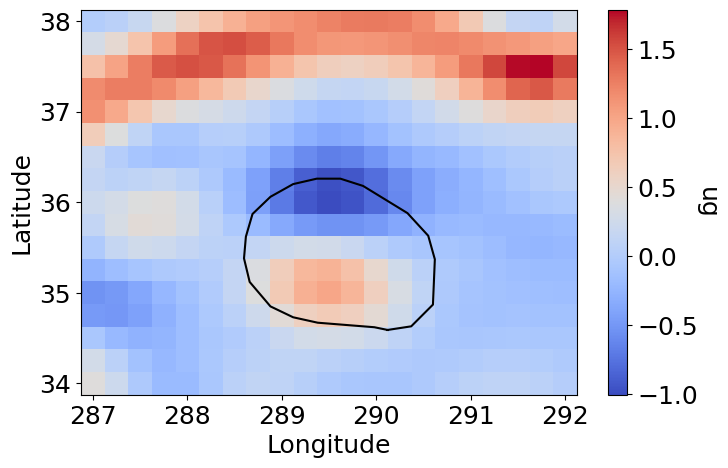

In [52]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))

plot = ax.pcolormesh(oscar_ds_masked.lon-360,oscar_ds_masked.lat,oscar_ds_masked.ug[0],cmap='coolwarm')
ax.plot(contour_lons-360,contour_lats,zorder=100,c='k')

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('ug', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.show()

<Figure size 640x480 with 0 Axes>

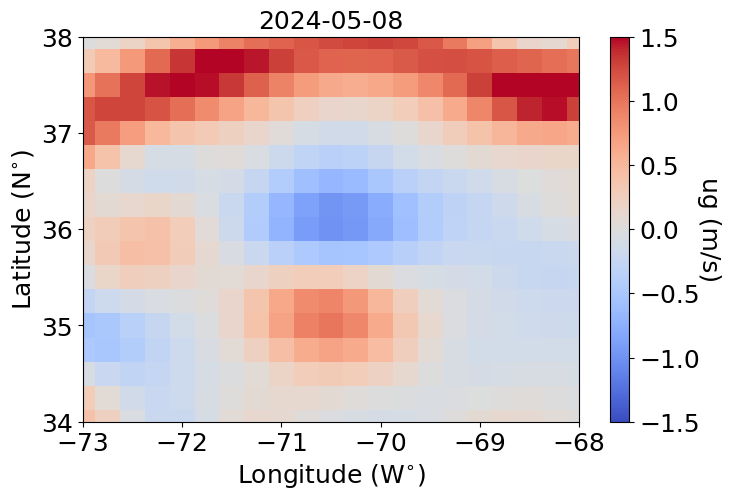

In [62]:
plt.clf()

magnitude = 1.5

fig,ax=plt.subplots(figsize=(8,5))

plot = ax.pcolormesh(oscar_ds_masked.lon-360,oscar_ds_masked.lat,oscar_ds_masked.ug[0],cmap='coolwarm',vmin=-magnitude,vmax=magnitude)

#ax.pcolormesh(grid_x-360,grid_y,ug1,cmap='coolwarm',vmin=-magnitude,vmax=magnitude)
#ax.pcolormesh(grid_x-360,grid_y,ug2,cmap='coolwarm',vmin=-magnitude,vmax=magnitude)
#ax.plot(contour_lons-360,contour_lats,zorder=100,c='k')

cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('ug (m/s)', rotation=270, labelpad=15)

ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

ax.set_xlim([lonmin,lonmax])
ax.set_ylim([latmin,latmax ])

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (W$^{\circ}$)')

plt.show()